In [1]:
# Import Data Science Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
# from sklearn.model_selection import train_test_split
import seaborn as sns

sns.set_style('darkgrid')

# Tensorflow Libraries
from tensorflow.keras import layers, Model
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint # Callback 
from tensorflow.keras.optimizers import Adam

# System libraries
from pathlib import Path

# Metrics
from sklearn.metrics import classification_report, confusion_matrix

# Pickle
import pickle

# Load Data

In [12]:
train_data = "../train/"
validation_data = '../valid/'
test_data = '../test/'

def load_data(path):
    dir = Path(path)
    hostile_data = list(dir.glob(r'hostile_images/*.jpg'))
    hostile_data = pd.Series(hostile_data, name='filepath').astype(str)
    hostile_label = pd.Series(['hostile']*len(hostile_data), name='label')
    hostile_df = pd.concat([hostile_data, hostile_label], axis=1)

    non_hostile_data = list(dir.glob(r'non_hostile_images/*.jpg'))
    non_hostile_data = pd.Series(non_hostile_data, name='filepath').astype(str)
    non_hostile_label = pd.Series(['non_hostile']*len(non_hostile_data), name='label')
    non_hostile_df = pd.concat([non_hostile_data, non_hostile_label], axis=1)

    combined_df = pd.concat([hostile_df, non_hostile_df], ignore_index=True)
    return combined_df

train_df = load_data(train_data)
valid_df = load_data(validation_data)
test_df = load_data(test_data)
print(train_df.shape)
print(valid_df.shape)
print(test_df.shape)
train_df.head()

(4901, 2)
(1226, 2)
(682, 2)


,filepath,label
0,train\hostile_images\0.jpg,hostile
1,train\hostile_images\10.jpg,hostile
2,train\hostile_images\100.jpg,hostile
3,train\hostile_images\101.jpg,hostile
4,train\hostile_images\102.jpg,hostile


## Data Preprocessing

In [13]:
image_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.inception_v3.preprocess_input
)

BATCH_SIZE = 32
TARGET_SIZE = (224, 224)

train_images = image_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepath',
    y_col='label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=111
)

val_images = image_generator.flow_from_dataframe(
    dataframe=valid_df,
    x_col='filepath',
    y_col='label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=111
)

test_images = image_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='filepath',
    y_col='label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 4901 validated image filenames belonging to 2 classes.
Found 1226 validated image filenames belonging to 2 classes.
Found 682 validated image filenames belonging to 2 classes.


In [14]:
# Data Augmentation Step
augment = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(224,224),
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.experimental.preprocessing.RandomFlip("horizontal"),
  layers.experimental.preprocessing.RandomRotation(0.1),
  layers.experimental.preprocessing.RandomZoom(0.1),
  layers.experimental.preprocessing.RandomContrast(0.1),
])

## Model Training

In [15]:
# Load the pretained model
pretrained_model = tf.keras.applications.inception_v3.InceptionV3(
    input_shape=(224, 224, 3),
    include_top=False, # For transfer learning later
    weights='imagenet',
    pooling='max'
)

pretrained_model.trainable = False

In [16]:
# Create checkpoint callback
checkpoint_path = "classification_model_checkpoint"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

In [17]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 5 epochs
early_stopping = EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 5,
                               restore_best_weights = True) # if val loss decreases for 5 epochs in a row, stop training

In [66]:
inputs = pretrained_model.input
x = augment(inputs)

x = Dense(128, activation='relu')(pretrained_model.output)
x = Dropout(0.45)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.45)(x)

# only 2 labels
outputs = Dense(2, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=Adam(0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=100,
    callbacks=[
        early_stopping,
        checkpoint_callback
    ]
)

Epoch 1/100
154/154 [==============================] - 559s 4s/step - loss: 0.3680 - accuracy: 0.8912 - val_loss: 0.0880 - val_accuracy: 0.9690
Epoch 2/100
154/154 [==============================] - 525s 3s/step - loss: 0.1309 - accuracy: 0.9572 - val_loss: 0.0425 - val_accuracy: 0.9853
Epoch 3/100
154/154 [==============================] - 483s 3s/step - loss: 0.0803 - accuracy: 0.9739 - val_loss: 0.0317 - val_accuracy: 0.9886
Epoch 4/100
154/154 [==============================] - 520s 3s/step - loss: 0.0525 - accuracy: 0.9806 - val_loss: 0.0220 - val_accuracy: 0.9927
Epoch 5/100
154/154 [==============================] - 498s 3s/step - loss: 0.0397 - accuracy: 0.9851 - val_loss: 0.0164 - val_accuracy: 0.9959
Epoch 6/100
154/154 [==============================] - 249s 2s/step - loss: 0.0271 - accuracy: 0.9908 - val_loss: 0.0164 - val_accuracy: 0.9951
Epoch 7/100
154/154 [==============================] - 261s 2s/step - loss: 0.0254 - accuracy: 0.9906 - val_loss: 0.0150 - val_accuracy:

In [18]:
# save the model to disk
model.save('../saved_models/model_inceptionv3.h5')
 
# load the model from disk
loaded_model = tf.keras.models.load_model('../saved_models/model_inceptionv3.h5')

In [3]:
with open('../saved_models/train_inceptionv3_history', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

history_dict = pickle.load(open('../saved_models/train_inceptionv3_history', "rb"))
print(history_dict['accuracy'])

[0.8912466764450073, 0.9571515917778015, 0.9738828539848328, 0.9806162118911743, 0.9851050972938538, 0.990818202495575, 0.9906141757965088, 0.9930626153945923, 0.9938787817955017, 0.9946949481964111, 0.9957151412963867, 0.9959192276000977, 0.99632728099823, 0.9969394207000732, 0.9971434473991394, 0.998163640499115, 0.99632728099823, 0.9969394207000732, 0.9969394207000732, 0.9983676671981812, 0.9987757802009583]


## Model Evaluation

In [21]:
loaded_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 111, 111, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_94 (BatchN  (None, 111, 111, 32  96         ['conv2d_94[0][0]']              
 ormalization)                  )                                                           

In [22]:
results = loaded_model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.00551
Test Accuracy: 99.85%


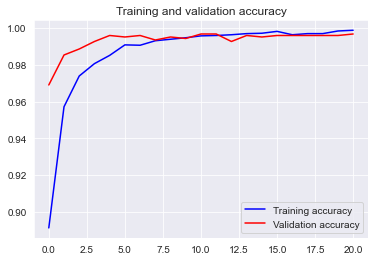

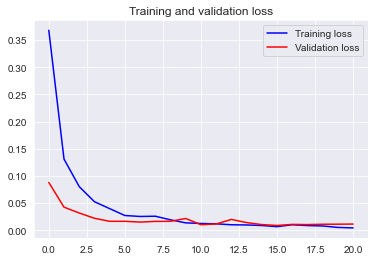

In [23]:
accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')

plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')

plt.title('Training and validation loss')
plt.legend()
plt.show()

In [24]:
# History of model training
hist = pd.DataFrame({'loss':loss,'accuracy':accuracy,  'val_loss':val_loss, 'val_accuracy':val_accuracy})

## Predictions

In [25]:
# Predict the label of the test_images
pred = loaded_model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

22/22 [==============================] - 23s 989ms/step
The first 5 predictions: ['hostile', 'hostile', 'hostile', 'hostile', 'hostile']


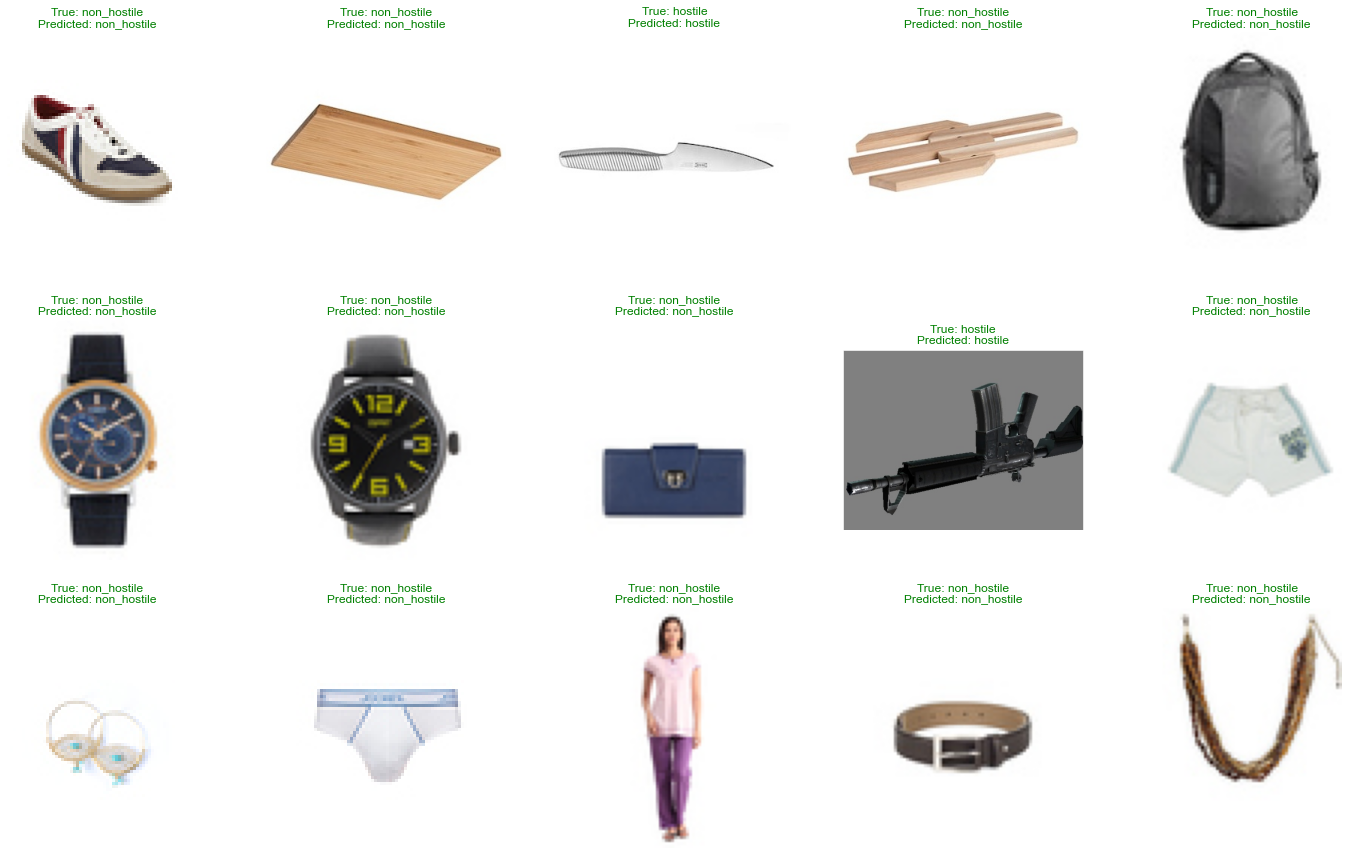

<Figure size 432x288 with 0 Axes>

In [26]:
# Display 25 random pictures from the dataset with their labels
random_index = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.filepath.iloc[random_index[i]]))
    if test_df.label.iloc[random_index[i]] == pred[random_index[i]]:
        color = "green"
    else:
        color = "red"
    ax.set_title(f"True: {test_df.label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

## Results

In [28]:
y_test = list(test_df.label)
report = classification_report(y_test, pred, output_dict=True, digits=4)
df = pd.DataFrame(report).transpose()
df

,precision,recall,f1-score,support
hostile,1.000000,0.982143,0.990991,56.000000
non_hostile,0.998405,1.000000,0.999202,626.000000
accuracy,0.998534,0.998534,0.998534,0.998534
macro avg,0.999203,0.991071,0.995096,682.000000
weighted avg,0.998536,0.998534,0.998528,682.000000


## Extra Tests
On unseen data taken from the internet. This data contents images of scanned luggages and other hostile/non-hostile items and will be used to gauge the generalisability of this model.

In [29]:
unseen_test_data = '../unseen_test/'
unseen_test_df = load_data(unseen_test_data)
print(unseen_test_df.shape)

(20, 2)


In [30]:
unseen_test_images = image_generator.flow_from_dataframe(
    dataframe=unseen_test_df,
    x_col='filepath',
    y_col='label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 20 validated image filenames belonging to 2 classes.


In [31]:
# Predict the label of the test_images
pred1 = loaded_model.predict(unseen_test_images)
pred1 = np.argmax(pred1,axis=1)

# Map the label
labels1 = (train_images.class_indices)
labels1 = dict((v,k) for k,v in labels1.items())
pred1 = [labels1[k] for k in pred1]

1/1 [==============================] - 1s 526ms/step


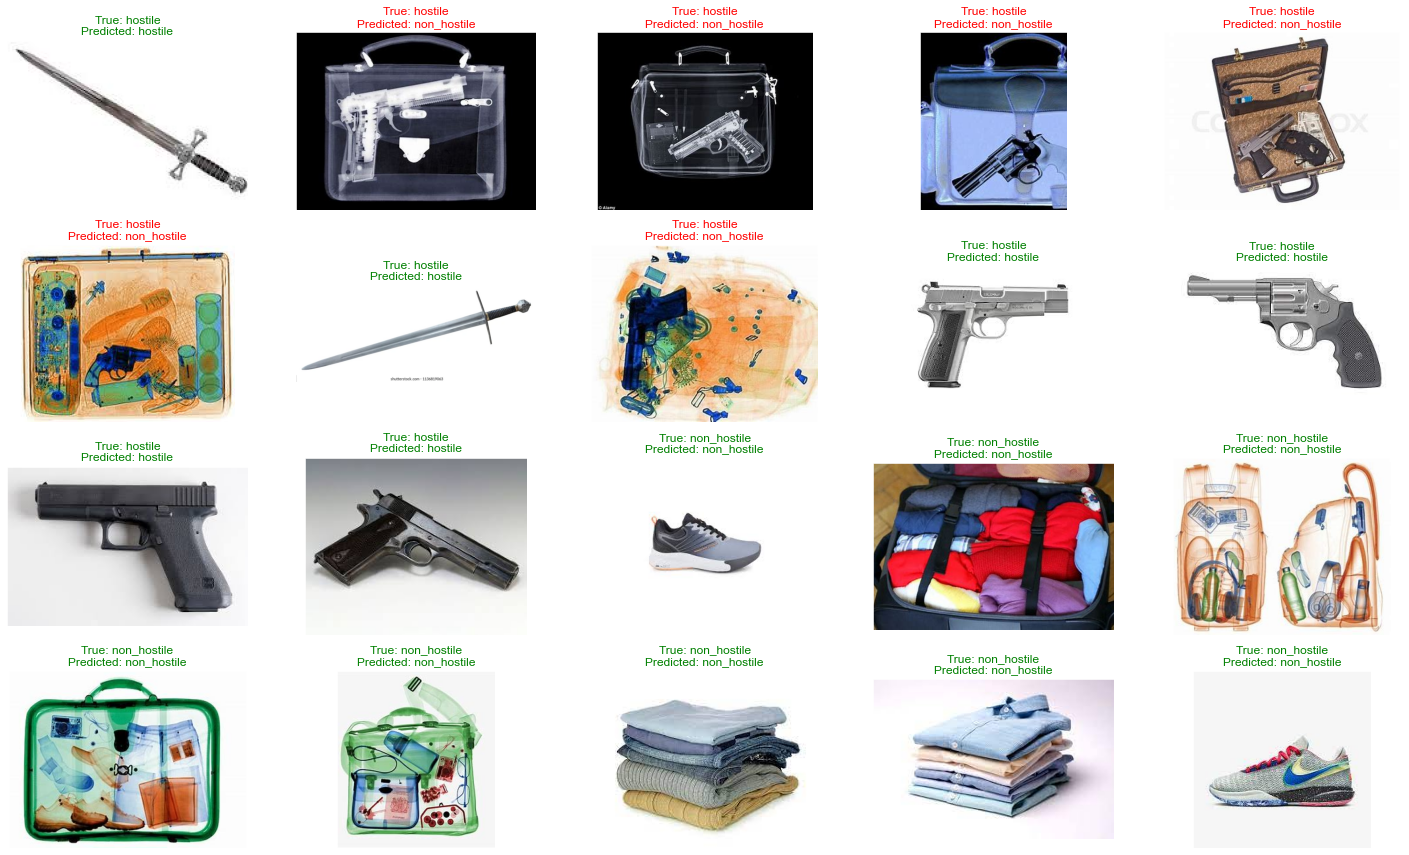

<Figure size 432x288 with 0 Axes>

In [34]:
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(unseen_test_df.filepath.iloc[i]))
    if unseen_test_df.label.iloc[i] == pred1[i]:
        color = "green"
    else:
        color = "red"
    ax.set_title(f"True: {unseen_test_df.label.iloc[i]}\nPredicted: {pred1[i]}", color=color)
plt.show()
plt.tight_layout()

### Augmented Images

Text(0.5, 1.0, 'Original Image')

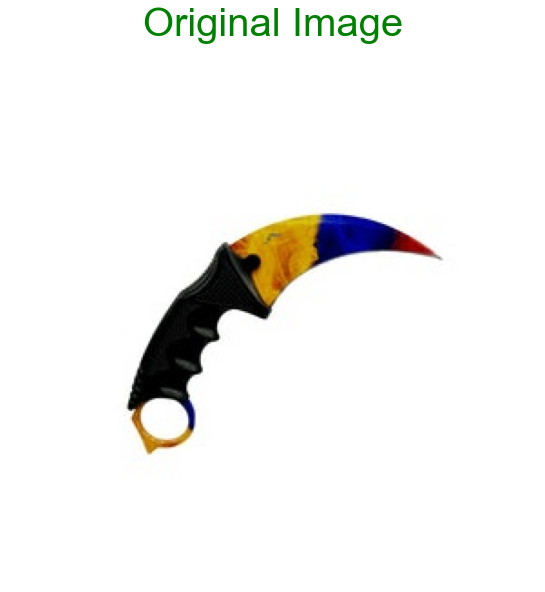

In [115]:
img = Path('../train/hostile_images/241.jpg')
plt.figure(figsize=(10, 10))
plt.imshow(plt.imread(img))
plt.grid(False)
plt.axis('off')
plt.title("Original Image", color = 'green', fontsize = 40)

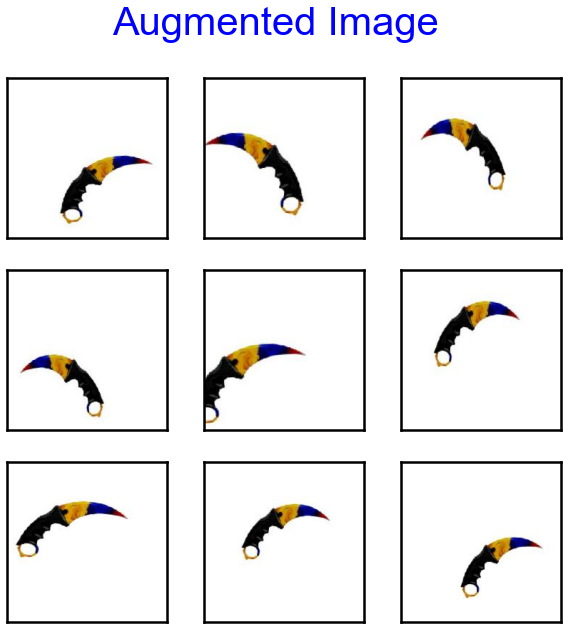

<Figure size 432x288 with 0 Axes>

In [117]:
# fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 10),
#                         subplot_kw={'xticks': [], 'yticks': []})

# aug_dir = Path('aug_train/')
# aug_img = list(aug_dir.glob(r'aug-_4_*.jpg'))
# aug_img = aug_img[:9]

# for i, ax in enumerate(axes.flat):
#     ax.imshow(plt.imread(aug_img[i]))

# plt.rcParams["axes.edgecolor"] = "black"
# plt.rcParams["axes.linewidth"] = 2.50
# color = "blue"
# plt.suptitle("Augmented Image", color=color, fontsize = 40)
# plt.show()
# plt.tight_layout()